 # 통계적 시계열 모델링

# 1.환경준비

## (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import *
from sklearn.model_selection import train_test_split

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

## (2) 함수 생성

### 1) 결과 시각화

In [2]:
def plot_model_result(y_train, y_val, pred) :
    pred = pd.Series(pred, index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### 2) 잔차분석

In [3]:
def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()

## (3) 데이터 불러오기

In [4]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/SeoulBike_Simple.csv'
bike = pd.read_csv(path)
bike['Datetime'] = pd.to_datetime(bike['Datetime'] )
bike.rename(columns={'Rented Bike Count':'Count'}, inplace = True)
bike = bike.loc[bike['Datetime'].between('2018-06-11','2018-08-13', inclusive = 'left'),
                ['Datetime', 'Temperature', 'Humidity','Count']]
bike.reset_index(drop = True, inplace = True)

## (4) 데이터 둘러보기

In [5]:
bike.describe(include = 'all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Datetime,1512,1512,2018-06-11,1,2018-06-11,2018-08-12 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Temperature,1509.0,NaN,NaT,NaN,NaT,NaT,26.983764,4.75233,16.3,23.2,27.1,30.4,39.4
Humidity,1509.0,NaN,NaT,NaN,NaT,NaT,66.153744,16.860646,23.0,53.0,66.0,80.0,98.0
Count,1512.0,NaN,NaT,NaN,NaT,NaT,1036.53836,685.269919,9.0,543.5,909.0,1426.25,3556.0


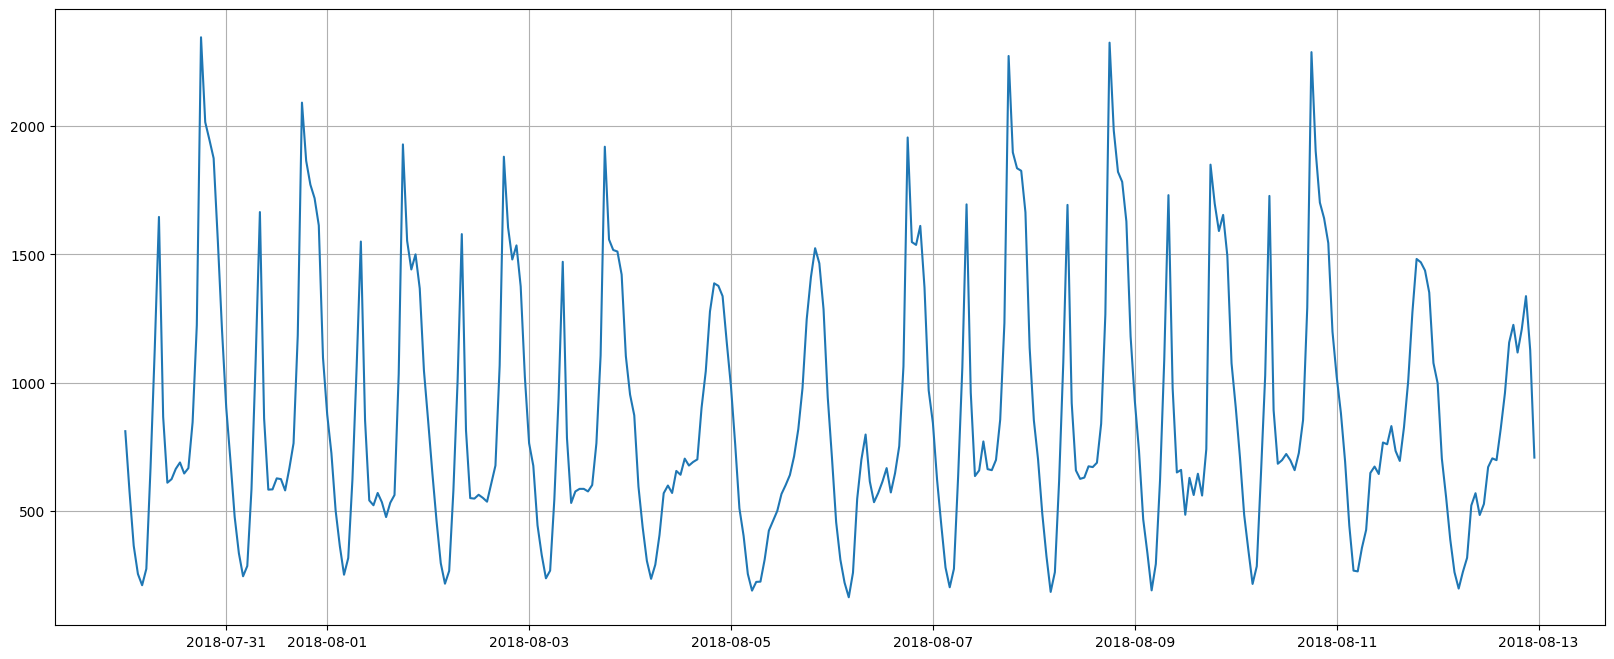

In [6]:
# 마지막 14일의 그래프를 그려 봅시다.
size = 24 * 14
temp = bike.iloc[-size:]
plt.figure(figsize = (20,8))
plt.plot('Datetime', 'Count', data = temp)
plt.grid()
plt.show()

# 2.기본 전처리

## (1) y 만들기

In [7]:
data = bike.copy()

In [8]:
data['y'] = data['Count'].shift(-2)

In [9]:
data = data.iloc[:-2]

## (2) NaN 조치

In [10]:
data.fillna(method = 'ffill', inplace = True)

## (3) 데이터 분할

### 1) x, y 나누기

In [11]:
target = 'y'

x = data.drop([target, 'Datetime'], axis = 1) #제거할 때, date도 제거
y = data.loc[:, target]

### 2) train, val 분할
* 1회 분할 : train_test_split( x, y, test_size= , shuffle = False)
    * test_size : 소수 - 비율, 자연수 - 갯수
    * shuffle = False : 섞지 말고 데이터 끝에서 test_size 만큼 자르기

In [12]:
val_size = 24 * 14
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = val_size, shuffle = False)

# 3.모델링1 : ARIMA

## (1) y 값 살펴보기

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.05433
* 자기상관성 확인(ACF, PACF)


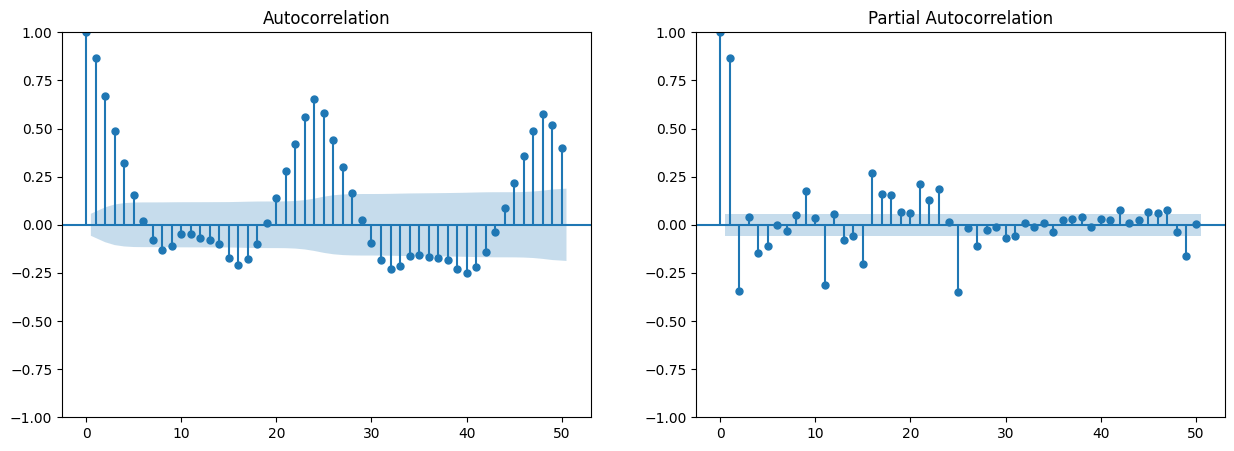

In [13]:
residual_diag(y_train, lags = 50)

## (2) 모델링 : 초기모델

* p, d, q 값을 어떻게 정해야 할까요?
* AR의 p 차수와 MA q 차수 모두 값이 필요해 보입니다. 일단 1, 1을 지정합시다.
* d : 정상성을 띤 데이터가 아니므로 1로 지정

### 1) 학습

* sm.tsa.SARIMAX(train, order=(p,d,q)).fit()
    * 모델 선언시 train이 포함
    * .fit()으로 학습.

In [14]:
# ARIMA 모델링
m1 = sm.tsa.SARIMAX(y_train, order=(1,1,1)).fit()

### 2) 평가

#### ① 잔차진단

* 모델.resid : 잔차를 뽑을 수 있습니다.
* 위에서 만든 함수 residual_diag 를 사용하여 잔차진단을 해 봅시다.

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


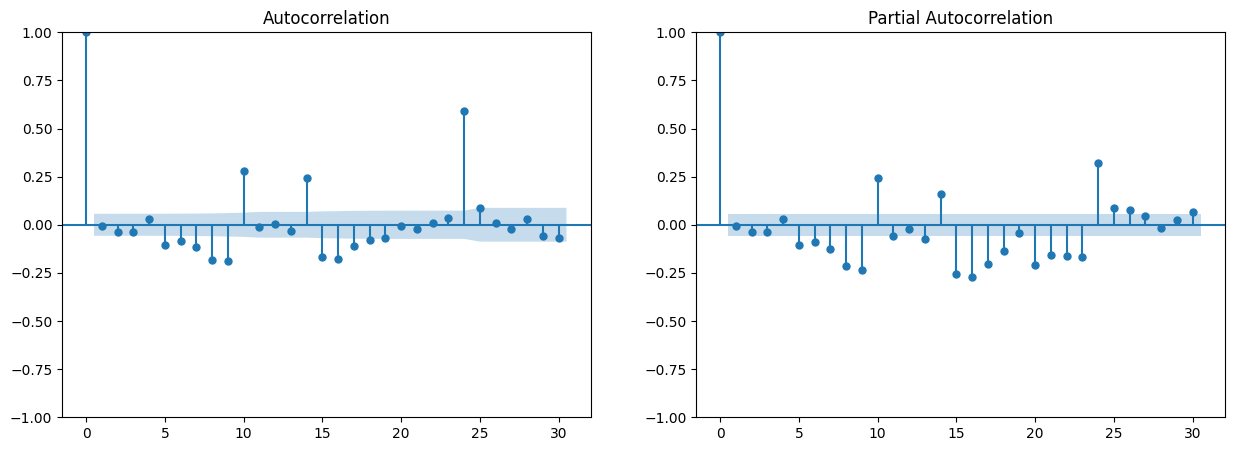

In [15]:
residuals = m1.resid
residual_diag(residuals)

#### ② AIC
* 선형 모델에서의 적합도와, feature가 과도하게 늘어나는 것을 방지하도록 설계된 통계량이 AIC 입니다.
* 값이 작을 수록 좋은 모델
* 공식 : 𝐴𝐼𝐶=−2 ln⁡(𝐿)+2𝑘 ➡ - 모델의 적합도 + 변수의 갯수
* SARIMAX 모델.aic로 쉽게 통계량을 구할 수 있습니다.

In [16]:
print('model1 AIC :', m1.aic)

model1 AIC : 17126.121691421475


#### ③ Validation

시계열 데이터로 실제값과 예측값에 대해 비교하여 그래프를 그려봅시다.

In [17]:
pred = m1.forecast(size)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  : ', r2_score(y_val, pred))

MAE : 454.18091465758454
MAPE: 0.8584310470715723
R2  :  -0.12551538829247355


* 결과 시각화

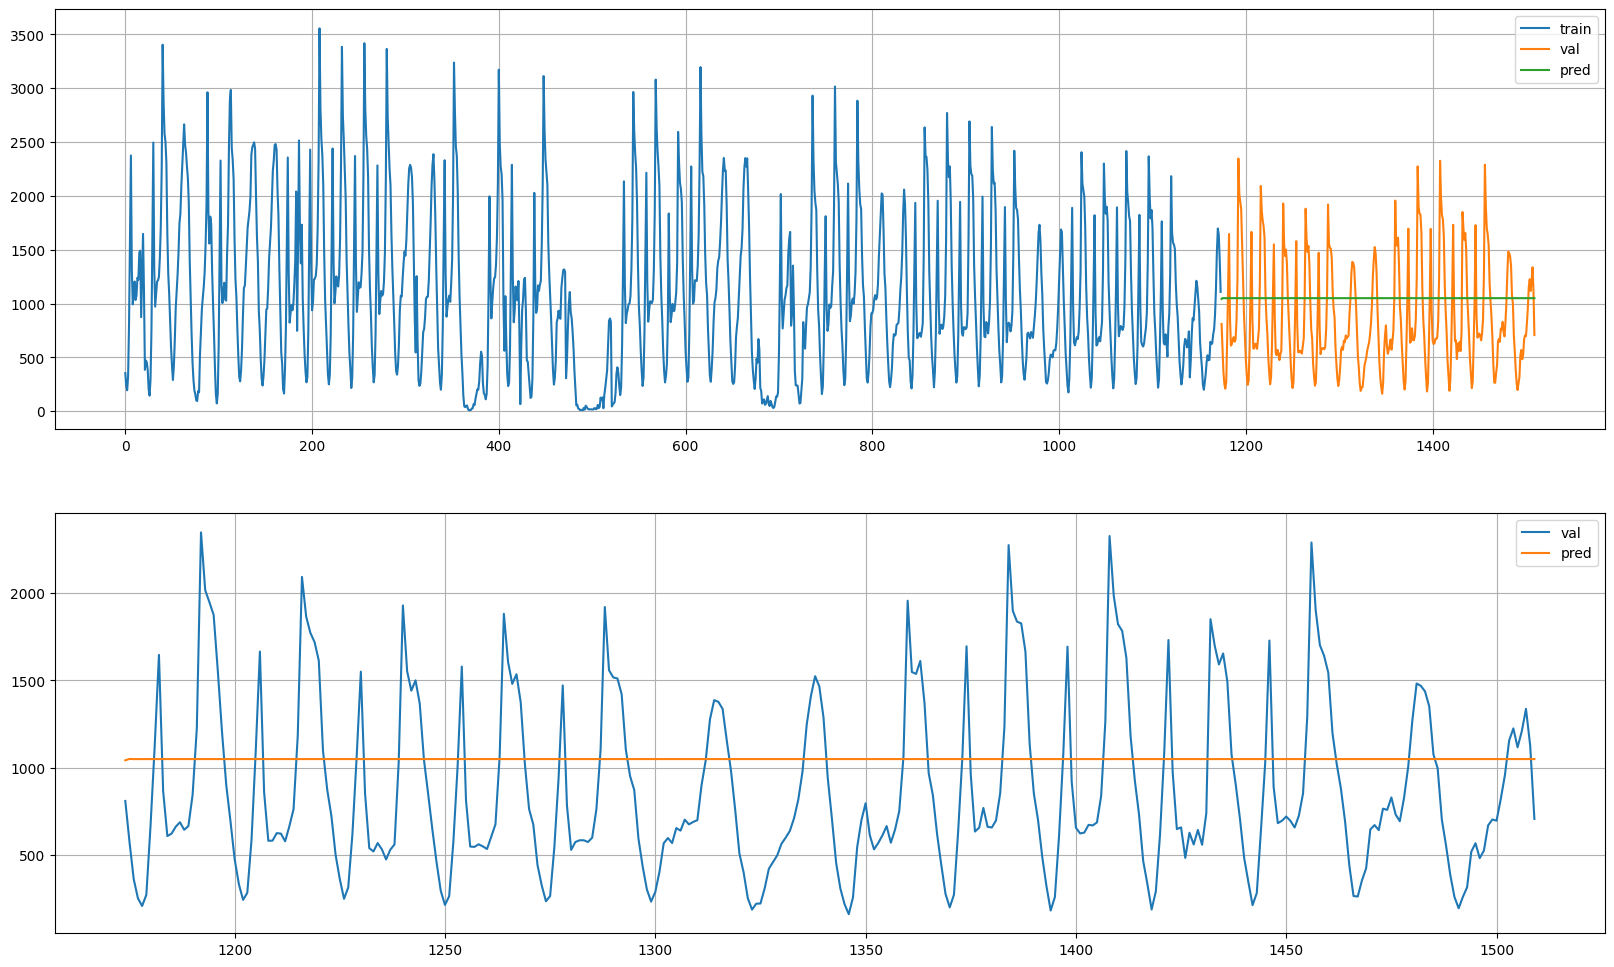

In [18]:
plot_model_result(y_train, y_val, pred)

## (3) 하이퍼파라미터 튜닝

* 실제로 p, d, q를 찾는 과정은 마치 Grid Search 처럼 값을 조금씩 조정해가며  최적의 모델을 찾아가는 과정과 유사합니다.
* 3 ~ 5분 정도 소요됩니다.


### 1) 학습

In [19]:
from itertools import product

* 값의 범위 지정

In [20]:
# product 함수를 이용하여 값의 조합을 구성
p = [2,3,4,5]
q = [2,3,4,5]
d = [1]
iter = list(product(p,d,q))
iter

[(2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 1, 5),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (3, 1, 5),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4),
 (4, 1, 5),
 (5, 1, 2),
 (5, 1, 3),
 (5, 1, 4),
 (5, 1, 5)]

* 튜닝

In [21]:
# 반복문 진행율 확인
from tqdm import tqdm

In [22]:
# 빈 리스트
mae, aic = [],[]

# 반복문으로 모델 생성하고 mae, aic 값 계산 후 저장
for i in tqdm(iter) : # tqdm!
    model_fit = sm.tsa.SARIMAX(y_train, order=(i[0], i[1], i[2])).fit()
    pred = model_fit.forecast(val_size)
    mae.append(mean_absolute_error(y_val, pred))
    aic.append(model_fit.aic)

100%|██████████| 16/16 [01:26<00:00,  5.40s/it]


* 튜닝 결과 확인

In [23]:
# 가장 성능이 좋은 모델 조회
result = pd.DataFrame({'params(p,d,q)' : iter, 'mae' : mae, 'aic':aic})

display(result.loc[result['mae'] == result.mae.min()])
display(result.loc[result['aic'] == result.aic.min()])

,"params(p,d,q)",mae,aic
2,"(2, 1, 4)",323.076084,16967.64774


,"params(p,d,q)",mae,aic
14,"(5, 1, 4)",463.192554,16891.001797


In [24]:
result

,"params(p,d,q)",mae,aic
0,"(2, 1, 2)",465.933327,17007.489717
1,"(2, 1, 3)",466.547799,16951.177408
2,"(2, 1, 4)",323.076084,16967.647740
3,"(2, 1, 5)",466.194569,16953.690414
4,"(3, 1, 2)",478.966642,17045.286009
5,"(3, 1, 3)",466.124329,16961.333988
6,"(3, 1, 4)",453.020819,16955.684161
7,"(3, 1, 5)",464.261721,16930.241831
8,"(4, 1, 2)",489.070270,17039.751120
9,"(4, 1, 3)",433.242443,16986.549753


In [25]:
m1_1 = sm.tsa.SARIMAX(y_train, order=(2, 1, 4)).fit()

### 2) 평가

#### ① 잔차진단

* residual_diag

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


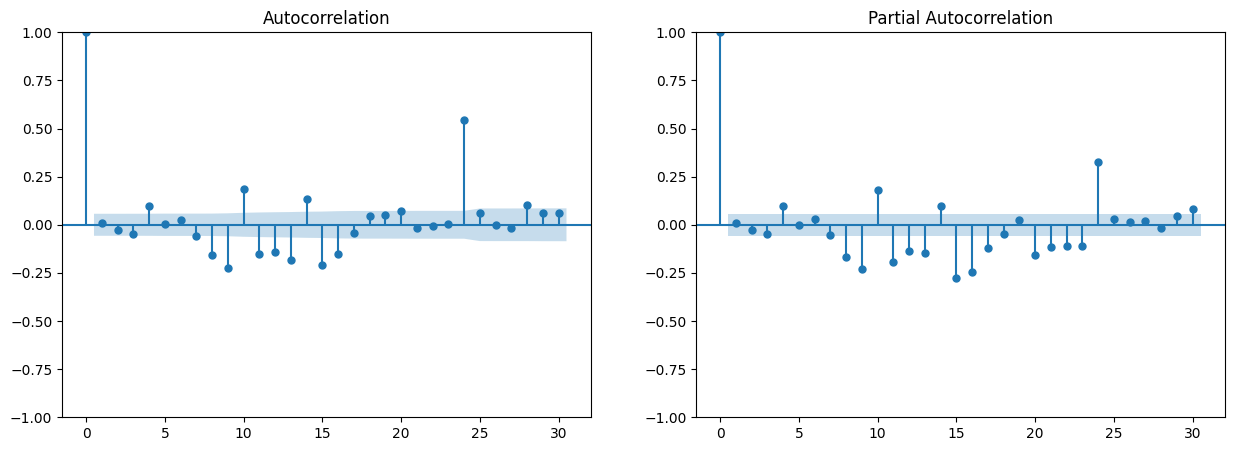

In [26]:
residuals = m1_1.resid
residual_diag(residuals)

#### ② AIC
* 선형 모델에서의 적합도와, feature가 과도하게 늘어나는 것을 방지하도록 설계된 통계량이 AIC 입니다.
* 값이 작을 수록 좋은 모델
* 공식 : 𝐴𝐼𝐶=−2 ln⁡(𝐿)+2𝑘 ➡ - 모델의 적합도 + 변수의 갯수

In [27]:
print('model AIC :', m1_1.aic)

model AIC : 16967.64774039511


#### ③ Validation

In [28]:
size

336

In [29]:
pred = m1_1.forecast(size)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  : ', r2_score(y_val, pred))

MAE : 323.07608364125446
MAPE: 0.642479042283773
R2  :  0.21895477052313583


* 결과 시각화

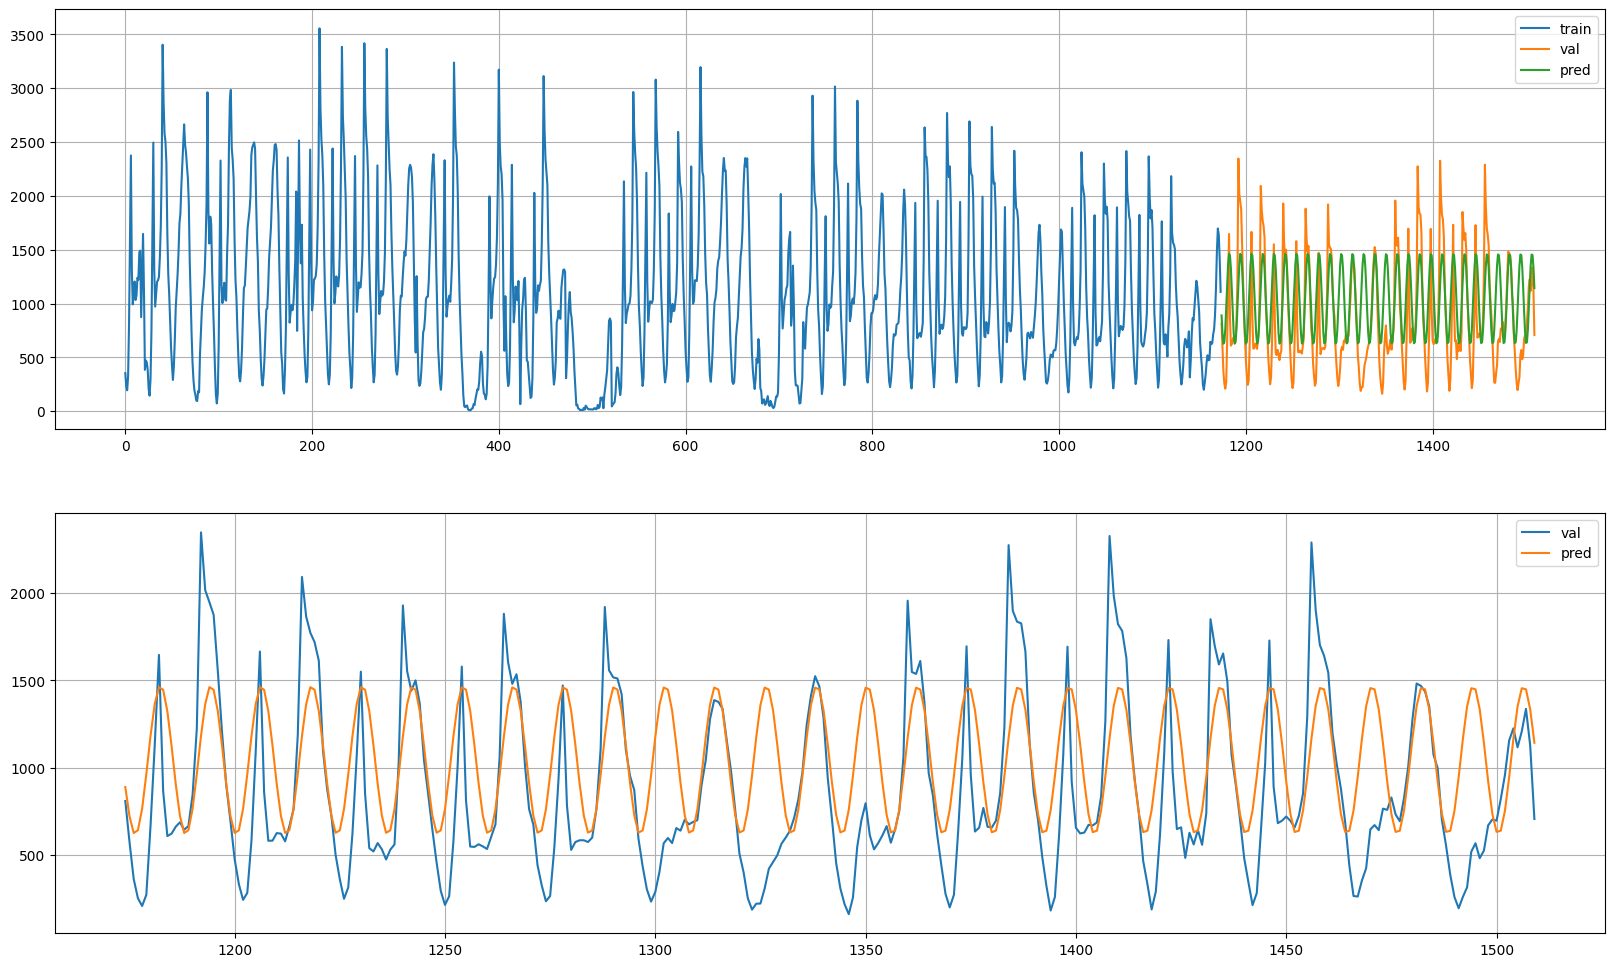

In [30]:
plot_model_result(y_train, y_val, pred)

# 4.모델링2 : SARIMA

## (1) 모델링 : 초기모델

### 1) 학습
* seasonality를 24로 두고 모델링을 수행해 봅시다.
* ARIMA 보다 시간이 더 걸립니다.

In [31]:
# SARIMA 모델링(1~2분 소요)
m2 = sm.tsa.SARIMAX(y_train, order=(2,1,4), seasonal_order=(1,1,1,24)).fit()

### 2) 평가

#### ① 잔차진단

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


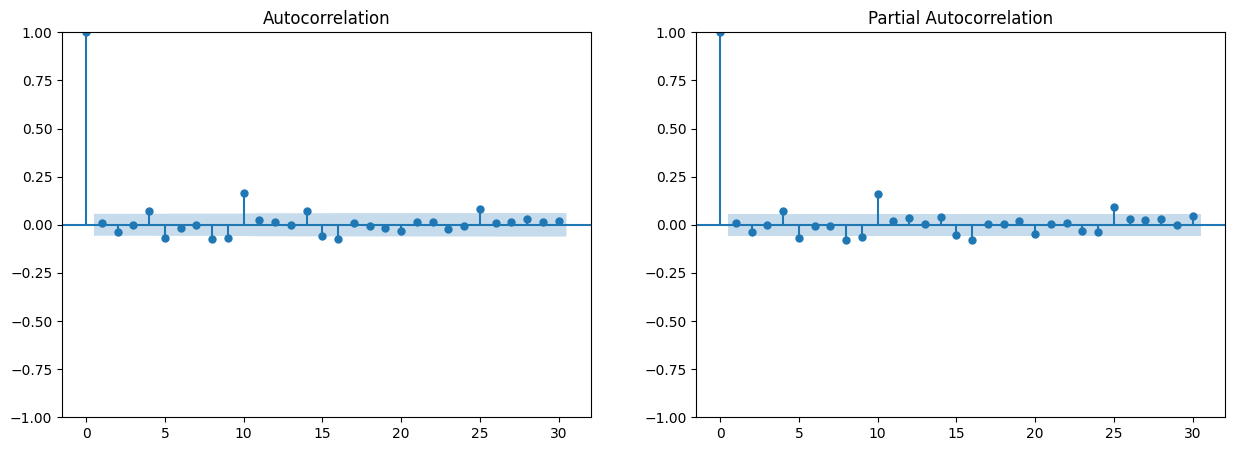

In [32]:
residuals = m2.resid
residual_diag(residuals)

#### ② AIC

In [33]:
print('model2_0 AIC :', m2.aic)

model2_0 AIC : 15857.38254445964


#### ③ Validation

In [34]:
pred = m2.forecast(size)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  : ', r2_score(y_val, pred))

MAE : 196.39115325133992
MAPE: 0.3141536310325688
R2  :  0.7487260600150247


* 결과 시각화

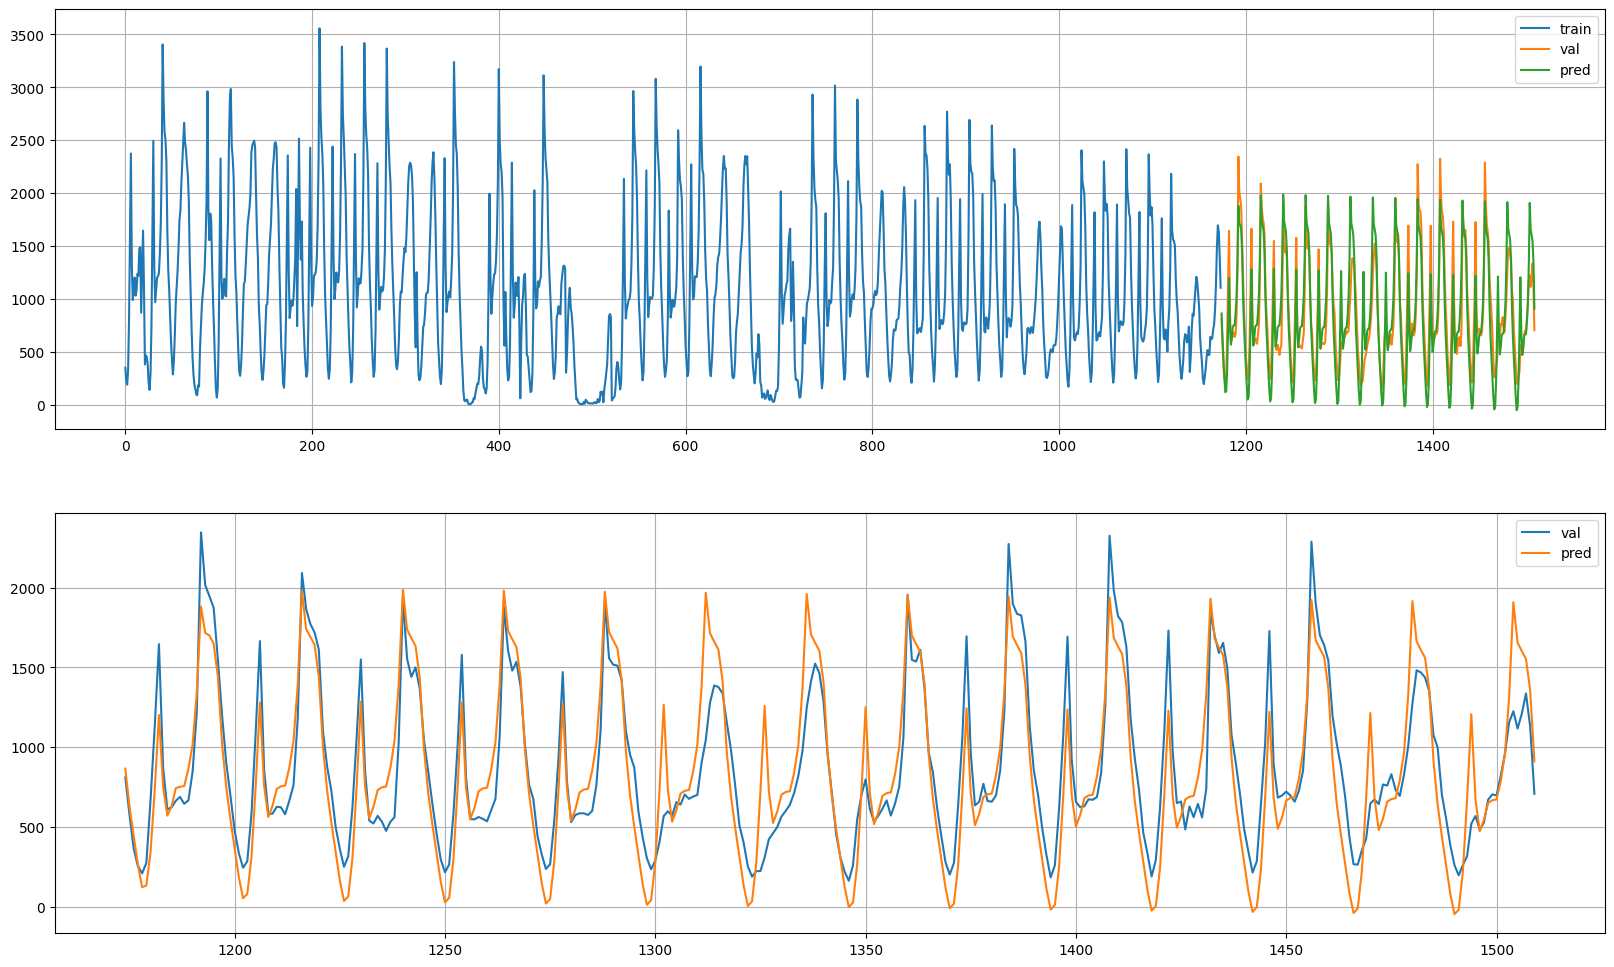

In [35]:
plot_model_result(y_train, y_val, pred)

## (2) 하이퍼파라미터 튜닝
* 약 10분 수행.
* 범위를 늘리면 시간이 훨씬 증가합니다

### 1) 학습

In [36]:
P = [1,2]
Q = [1,2]
D = [1]
mae, aic = [],[]
iter = list(product(P,D,Q))

for i in tqdm(iter) :
    model_fit = sm.tsa.SARIMAX(y_train, order=(2,1,4), seasonal_order=(i[0],i[1],i[2],24)).fit()
    pred = model_fit.forecast(size)
    mae.append( mean_absolute_error(y_val, pred))
    aic.append(model_fit.aic)

100%|██████████| 4/4 [08:29<00:00, 127.38s/it]


In [37]:
result = pd.DataFrame({'params(P,D,Q)' : iter, 'mae' : mae, 'aic':aic})

result

,"params(P,D,Q)",mae,aic
0,"(1, 1, 1)",196.391153,15857.382544
1,"(1, 1, 2)",207.737711,15881.351360
2,"(2, 1, 1)",191.895265,15917.075380
3,"(2, 1, 2)",196.592394,15861.044118


In [38]:
display(result.loc[result['mae'] == result.mae.min()])
display(result.loc[result['aic'] == result.aic.min()])

,"params(P,D,Q)",mae,aic
2,"(2, 1, 1)",191.895265,15917.07538


,"params(P,D,Q)",mae,aic
0,"(1, 1, 1)",196.391153,15857.382544


In [39]:
m2_1 = sm.tsa.SARIMAX(y_train, order=(2,1,4), seasonal_order=(2,1,1,24)).fit()

### 2) 평가

#### ① 잔차진단

* residual_diag

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


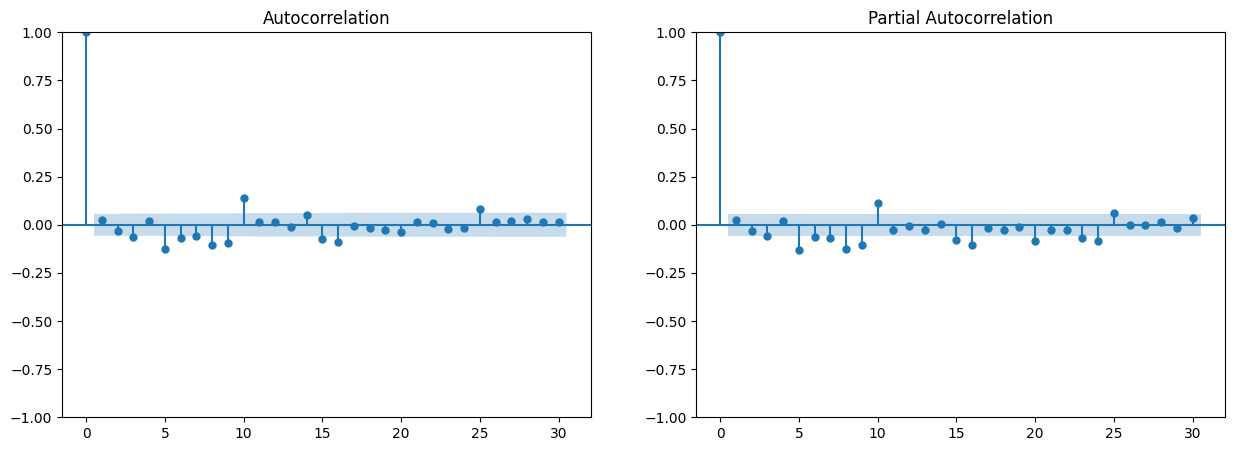

In [40]:
residuals = m2_1.resid
residual_diag(residuals)

#### ② AIC
* 선형 모델에서의 적합도와, feature가 과도하게 늘어나는 것을 방지하도록 설계된 통계량이 AIC 입니다.
* 값이 작을 수록 좋은 모델
* 공식 : 𝐴𝐼𝐶=−2 ln⁡(𝐿)+2𝑘 ➡ - 모델의 적합도 + 변수의 갯수

In [41]:
print('model2_1 AIC :', m2_1.aic)

model2_1 AIC : 15917.07538029482


#### ③ Validation

In [42]:
pred = m2_1.forecast(size)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  : ', r2_score(y_val, pred))

MAE : 191.89526525283185
MAPE: 0.29295460617001784
R2  :  0.7474585112654839


* 결과 시각화

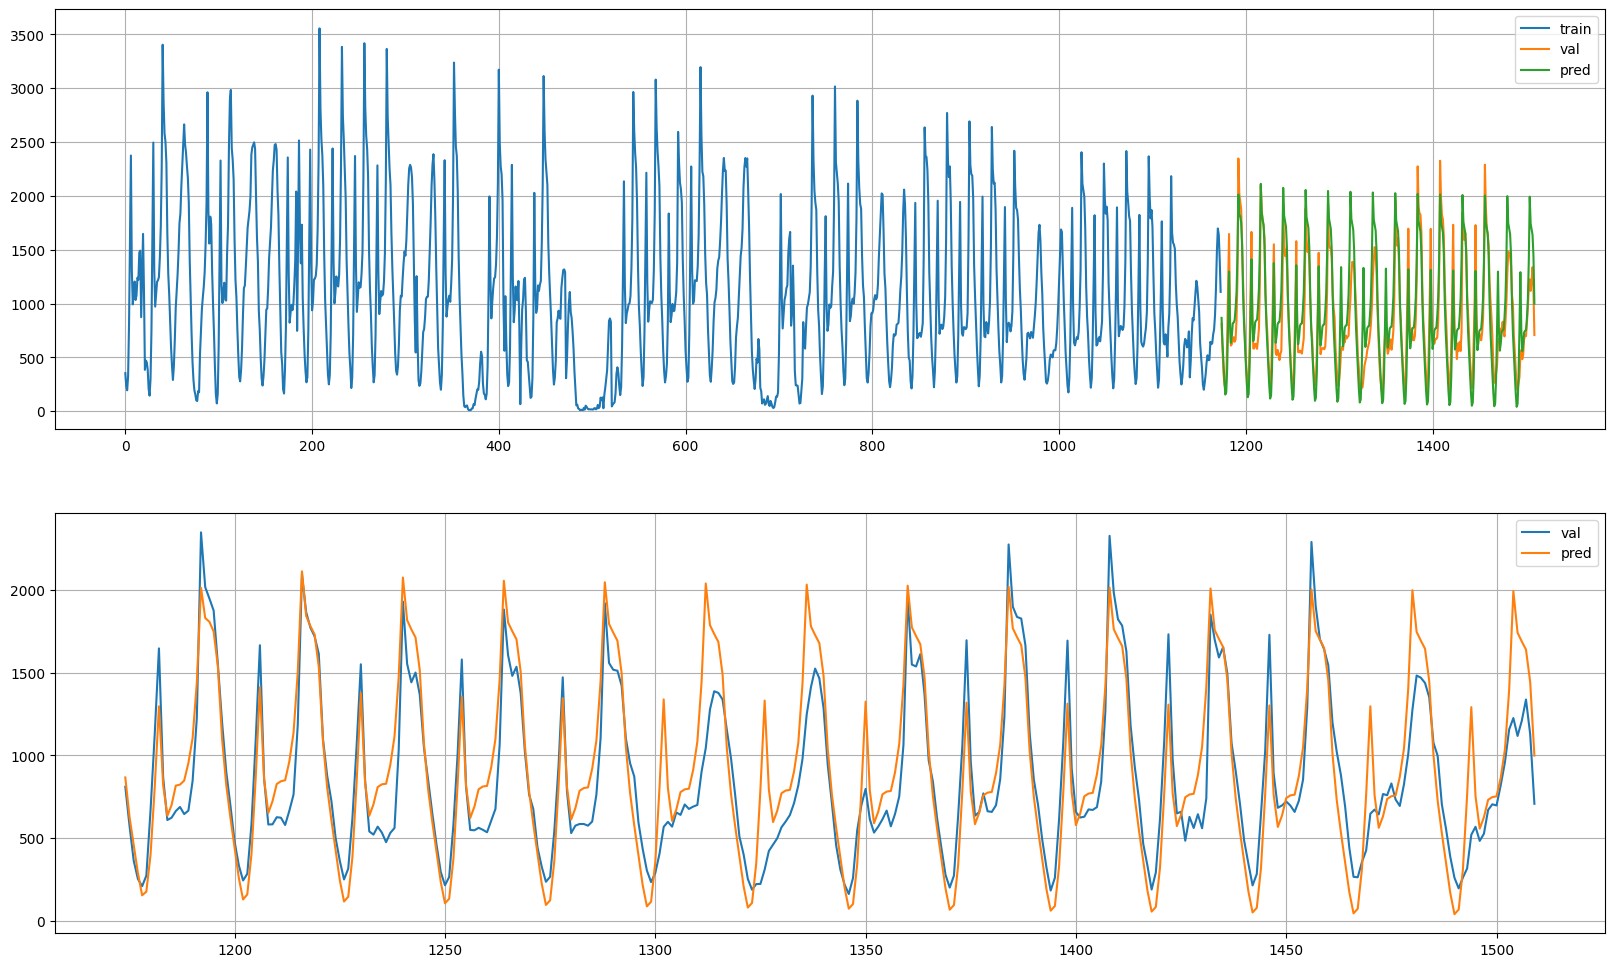

In [43]:
plot_model_result(y_train, y_val, pred)

# 5.모델링3 : SARIMAX

## (1) 전처리

* 요일 : feature중 요일을 추가합니다.
* 활동시간 구분 : 시간을 추출하고, 다음과 같이 범주로 생성합니다.
    * 0 : 활동 없음, 1 : 일상 활동시간, 2 : 출퇴근
    * 0~6 : 0
    * 7~8 : 2
    * 9~16: 1
    * 17~20 : 2
    * 21~23 : 0



In [57]:
data1 = data.copy()

* 요일

In [58]:
data1['Weekday'] = data1['Datetime'].dt.day_name()

data1.head()

,Datetime,Temperature,Humidity,Count,y,Weekday
0,2018-06-11 00:00:00,20.3,58.0,918,353.0,Monday
1,2018-06-11 01:00:00,19.8,59.0,555,232.0,Monday
2,2018-06-11 02:00:00,19.2,60.0,353,194.0,Monday
3,2018-06-11 03:00:00,18.8,61.0,232,324.0,Monday
4,2018-06-11 04:00:00,18.8,60.0,194,807.0,Monday


* 활동시간 구분


In [59]:
data1['Active'] = pd.cut(data1['Datetime'].dt.hour, bins=[0,6,8,16,20,23],
                         labels = [0,2,1,2,0], include_lowest = True,
                         ordered = False)

In [61]:
data1.head(10)

,Datetime,Temperature,Humidity,Count,y,Weekday,Active
0,2018-06-11 00:00:00,20.3,58.0,918,353.0,Monday,0
1,2018-06-11 01:00:00,19.8,59.0,555,232.0,Monday,0
2,2018-06-11 02:00:00,19.2,60.0,353,194.0,Monday,0
3,2018-06-11 03:00:00,18.8,61.0,232,324.0,Monday,0
4,2018-06-11 04:00:00,18.8,60.0,194,807.0,Monday,0
5,2018-06-11 05:00:00,18.8,61.0,324,1629.0,Monday,0
6,2018-06-11 06:00:00,18.6,61.0,807,2375.0,Monday,0
7,2018-06-11 07:00:00,19.1,59.0,1629,1307.0,Monday,2
8,2018-06-11 08:00:00,20.7,55.0,2375,992.0,Monday,2
9,2018-06-11 09:00:00,22.2,48.0,1307,1107.0,Monday,1


In [62]:
# 가변수화
cat_cols = ['Weekday','Active']
data1 = pd.get_dummies(data1, columns = cat_cols, drop_first = True)
data1.head()

,Datetime,Temperature,Humidity,Count,y,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Active_1,Active_2
0,2018-06-11 00:00:00,20.3,58.0,918,353.0,1,0,0,0,0,0,0,0
1,2018-06-11 01:00:00,19.8,59.0,555,232.0,1,0,0,0,0,0,0,0
2,2018-06-11 02:00:00,19.2,60.0,353,194.0,1,0,0,0,0,0,0,0
3,2018-06-11 03:00:00,18.8,61.0,232,324.0,1,0,0,0,0,0,0,0
4,2018-06-11 04:00:00,18.8,60.0,194,807.0,1,0,0,0,0,0,0,0


In [63]:
# 데이터 분할
target = 'y'
x = data1.drop([target, 'Datetime'], axis = 1) #제거할 때, date도 제거
y = data1.loc[:, target]

val_size = 24 * 14
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = val_size, shuffle = False)

## (2) 모델링
* 좀 더 걸립니다.(5분 이상..ㅜㅜ)

### 1) 학습

In [64]:
m3_1 = sm.tsa.SARIMAX(y_train, order=(2,1,4), seasonal_order=(2,1,1,24), exog=x_train).fit()

### 2) 평가

#### ① 잔차진단

* residual_diag

* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


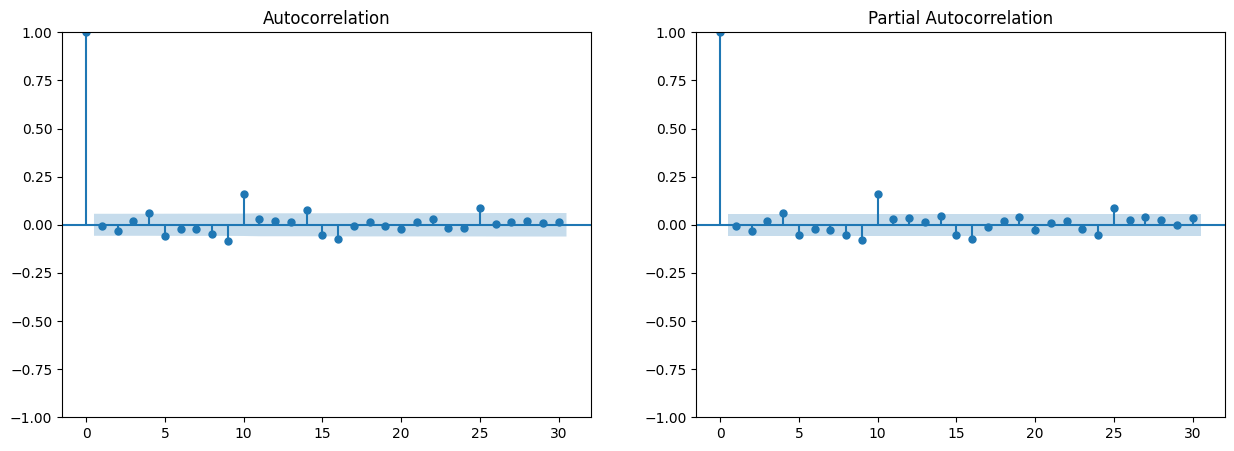

In [52]:
residuals = m3_1.resid
residual_diag(residuals)

#### ② AIC

In [53]:
print('m3_1 AIC :', m3_1.aic)

m3_1 AIC : 15899.180525604328


#### ③ Validation
SARIMAX 모델을 생성하고, 예측할 때는 exog=x_val 옵션이 들어가야 함.

In [54]:
pred = m3_1.forecast(size,  exog=x_val)

print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  : ', r2_score(y_val, pred))

MAE : 205.2427100952241
MAPE: 0.32367450120533503
R2  :  0.7076003107317268


* 결과 시각화

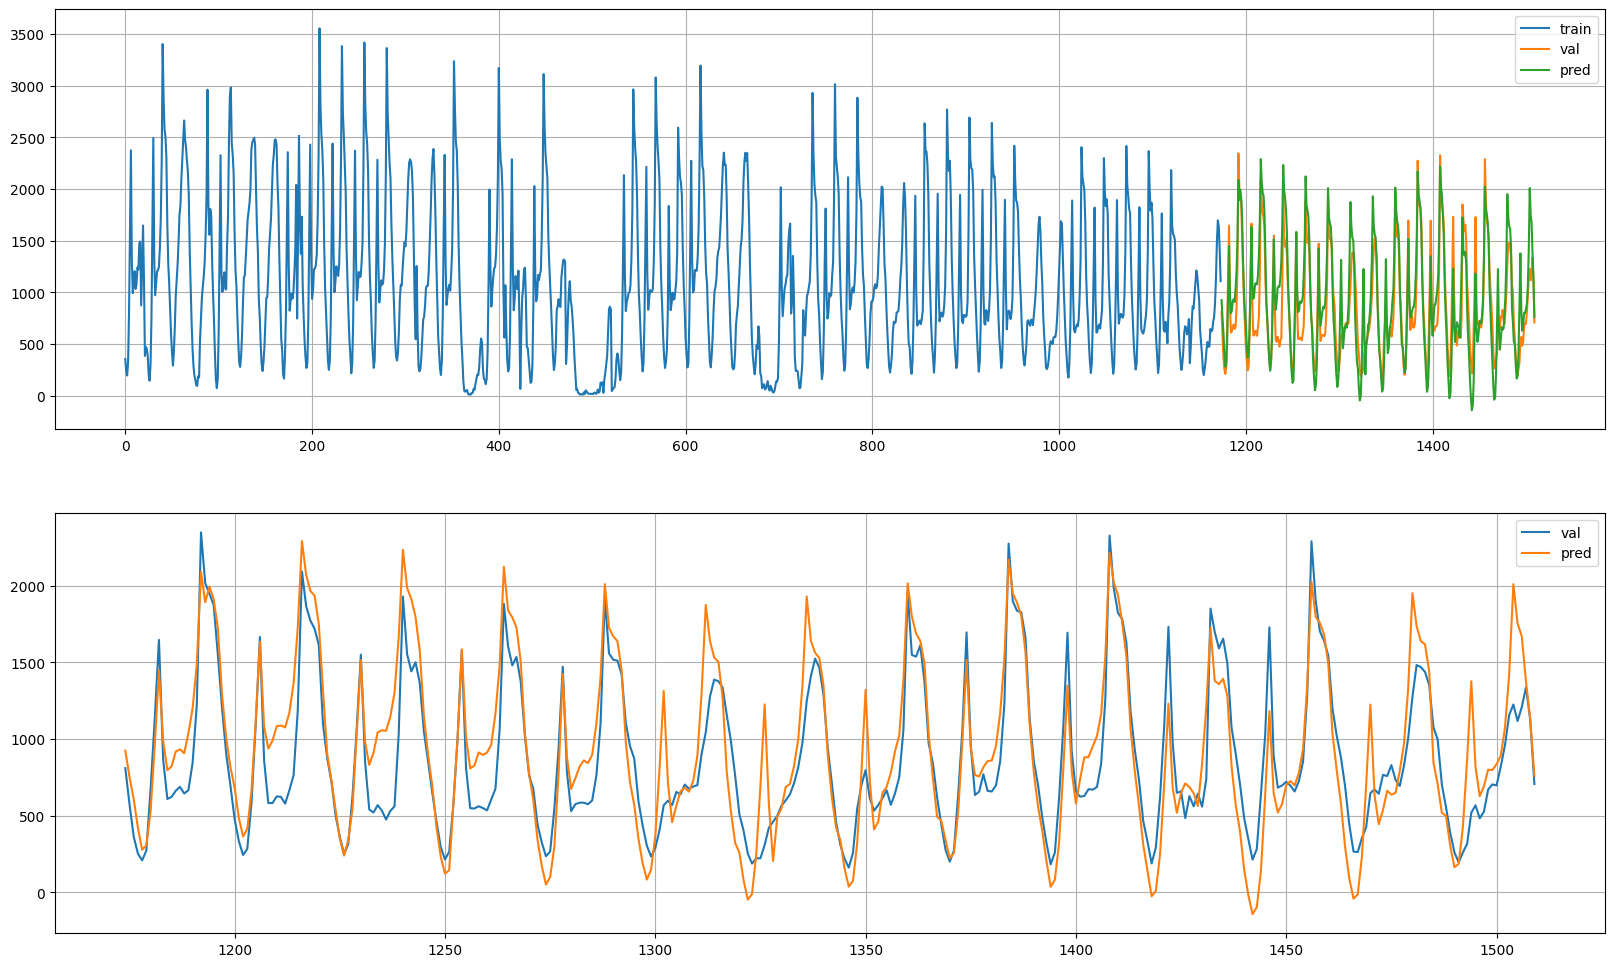

In [55]:
plot_model_result(y_train, y_val, pred)